# Fixture Modelling

How many goals are PL teams to score and concede in upcoming fixtures?

See here for some more technical details http://web.math.ku.dk/~rolf/teaching/thesis/DixonColes.pdf

## Setup

In [1]:
import pandas as pd
from datetime import timezone
import numpy as np
import scipy.stats
import scipy.optimize
import seaborn as sns

In [2]:
from src.utils.elo import Elo

In [5]:
!cd data/Fantasy-Premier-League && git pull # pull latest data

Already up to date.


## Load data

In [6]:
SEASONS = ['2018-19' ,'2019-20','2020-21', '2021-22',]

In [7]:
BASE = 'data/Fantasy-Premier-League'

In [8]:
combined = pd.DataFrame()
for season in SEASONS:
    df = pd.read_csv(f'{BASE}/data/{season}/fixtures.csv',parse_dates=['kickoff_time'])
    df['season'] = season
    combined = df.append(combined)

In [9]:
teams = pd.read_csv(f'{BASE}/data/master_team_list.csv')

the numbers aren't consistent across seasons so we merge on names and come up with our own numbering

In [10]:
def clean_names(combined, teams):    
    with_names = combined.copy()
    for suff in ['_h','_a']:
        with_names = with_names.merge(teams.rename(columns={'team':f"team{suff}",
                                                            "team_name":f'team_name{suff}'}),on = ['season',f'team{suff}'],how='left')
    unique_teams = list(set(with_names["team_name_h"]))
    name_mapping = dict(zip(unique_teams,range(len(unique_teams))))
    with_names['team_h'] = with_names.team_name_h.map(name_mapping) 
    with_names['team_a'] = with_names.team_name_a.map(name_mapping)
    with_names['days_since_fixture'] = (pd.Timestamp.utcnow() - with_names['kickoff_time']).dt.days
    return with_names, name_mapping

In [11]:
df, name_mapping = clean_names(combined, teams)

In [12]:
COLS = ['team_h','team_a','days_since_fixture','team_h_score','team_a_score']

In [13]:
results = df.loc[(df.finished),COLS].copy()
fixtures = df.loc[~df.finished,COLS].copy() 

In [14]:
assert df['team_name_h'].isna().sum() == 0

## Fit model - (1) Dixon-Coles like

We model a game with home/away score (x,y) as being

$\lambda_h = exp(\mu + \gamma + \alpha_{ha} - \alpha_{ad})$

$\lambda_a = exp(\gamma + \alpha_{aa} - \alpha_{hd})$

$p(x,y) = \frac{exp(-\lambda_h)(\lambda_h)^x}{x!} \frac{exp(-\lambda_a)(\lambda_a)^y}{y!}$

Each team has a coefficient for attacking/defending, and there is a fixed effect $\gamma$ and a home-team fixed effect $\mu$. 

In [15]:
def neg_log_likehihood(params, df, discount, n_teams):
    '''
    Based on model above, sum the negative log likelihood, discounted by time
    '''
    mu, gamma, *alpha  = params
    alpha_score = alpha[:n_teams]
    alpha_concede = alpha[n_teams:]
    home = mu +gamma + np.take(alpha_score,df.team_h) - np.take(alpha_concede,df.team_a)
    away = gamma + np.take(alpha_score,df.team_a) - np.take(alpha_concede,df.team_h)
    exp_home = np.exp(home)
    exp_away = np.exp(away)
    neg_log_lik = exp_home - (df["team_h_score"] * home) + exp_away - (df["team_a_score"] * away)
    loss = (np.exp(-discount * df["days_since_fixture"]) * neg_log_lik).sum()
    return loss / df.shape[0]

In [16]:
class DixonColes():
    def __init__(self, name_mapping, discount = 0.01):
        self.name_mapping = name_mapping
        self.n_teams = len(name_mapping)
        self.discount = discount 
        self.params = [0.0 for _ in range(2 + (2*self.n_teams))]
    
    def fit(self, X): 
        '''
        Minimise negative log-likelihood
        '''
        res = scipy.optimize.minimize(
            fun=neg_log_likehihood,
            x0=self.params,
            args=(X, self.discount, self.n_teams),
        )
        mu, gamma, *alpha = res['x']
        alpha_score = alpha[:self.n_teams]
        alpha_concede = alpha[self.n_teams:]
        return mu, gamma, alpha_score, alpha_concede
        


In [17]:
mu, gamma, alpha_score, alpha_concede =  DixonColes(name_mapping).fit(results)

In [18]:
mu

0.11106630549851934

In [19]:
form = pd.DataFrame(data=[name_mapping.keys(),alpha_score, alpha_concede]).T
form.columns = ['team', 'attack','defence']

In [20]:
form['total'] = form.attack + form.defence

This seams like a reasonable form ranking. I think the model is overrating Brentford a bit having never seen them before.

In [22]:
(form
 .iloc[list(set(fixtures.team_h))]
 .sort_values(by='total',ascending=False))

,team,attack,defence,total
13,Chelsea,0.542808,1.07638,1.61919
1,Man City,0.554144,0.783903,1.33805
17,Liverpool,0.835004,0.344575,1.17958
22,West Ham,0.333026,0.177803,0.510829
5,Crystal Palace,0.267153,-0.0130771,0.254076
9,Arsenal,0.0390444,0.178317,0.217361
24,Man Utd,0.249684,-0.20208,0.0476046
18,Leicester,0.208928,-0.217199,-0.00827132
15,Brentford,0.0917831,-0.141812,-0.0500288
16,Burnley,0.0838138,-0.137059,-0.0532449


## Fit Model (2) - ELO

In [24]:
results['outcome'] =(np.clip(results['team_h_score'] -results['team_a_score'],-1,1) + 1) / 2

In [25]:
results = results.sort_values(by='days_since_fixture',ascending=False)

In [26]:
elo =Elo(results,k_factor=35)
historic_elo, elo_ratings =elo.process_all_fixtures()

## Plot elo over time

In [27]:
inv_mapping = {v:k for k,v in name_mapping.items()}

In [28]:
historic_elo['name'] = historic_elo.team_h.map(inv_mapping)

In [29]:
historic_elo['neg_days_since_fixture'] = historic_elo['days_since_fixture'] * -1

In [30]:
filtered = historic_elo.loc[historic_elo.name.isin(['Chelsea', 'Man City', 'Liverpool','West Ham', 'Man Utd'])]

<AxesSubplot:xlabel='neg_days_since_fixture', ylabel='elo'>

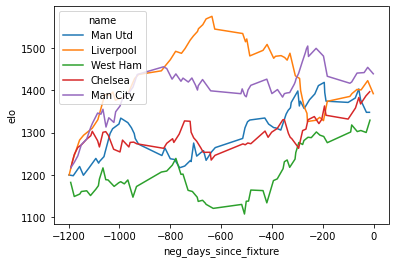

In [31]:
sns.lineplot(data=filtered, hue='name', y='elo', x='neg_days_since_fixture')

In [32]:
form['elo'] =pd.Series(elo_ratings).sort_index()

In [33]:
form.iloc[list(set(fixtures.team_h))].sort_values(by='total',ascending=False)


,team,attack,defence,total,elo
13,Chelsea,0.542808,1.07638,1.61919,1396.682021
1,Man City,0.554144,0.783903,1.33805,1446.186332
17,Liverpool,0.835004,0.344575,1.17958,1406.310357
22,West Ham,0.333026,0.177803,0.510829,1326.503712
5,Crystal Palace,0.267153,-0.0130771,0.254076,1226.328571
9,Arsenal,0.0390444,0.178317,0.217361,1316.329129
24,Man Utd,0.249684,-0.20208,0.0476046,1306.331470
18,Leicester,0.208928,-0.217199,-0.00827132,1246.948964
15,Brentford,0.0917831,-0.141812,-0.0500288,1167.639867
16,Burnley,0.0838138,-0.137059,-0.0532449,1147.294240


## Map form onto fixtures

In [34]:
CURRENT_GAMEWEEK = ((df.season == df.season.max()) & (df.finished == True)).sum() // 10 

map on the expected scoring rates

In [35]:
fixtures['score'] = np.exp(mu +gamma + np.take(alpha_score,fixtures.team_h) - np.take(alpha_concede,fixtures.team_a))
fixtures['opp_score'] = np.exp(gamma + np.take(alpha_score,fixtures.team_a) - np.take(alpha_concede,fixtures.team_h))

In [36]:
fixtures['elo_win'] =fixtures.apply(lambda row: elo.win_prob(row['team_h'],row['team_a']),axis=1)

In [37]:
fixtures['team'] = fixtures['team_h'].map(inv_mapping)
fixtures['opp'] = fixtures['team_a'].map(inv_mapping)

We flip home and away fixtures to have all fixtures for all teams in long format

In [38]:
upcoming_difficulties = fixtures[['team','opp','score','elo_win','opp_score','days_since_fixture']]

In [39]:
flipped_difficulties = upcoming_difficulties.copy().rename(columns={'team':'opp',
                                                                    'opp':'team',
                                                                    'score':'opp_score',
                                                                    'opp_score':'score',})
flipped_difficulties['elo_win'] = 1 -flipped_difficulties['elo_win']

In [40]:
assert (upcoming_difficulties.groupby('team')['opp'].count() + upcoming_difficulties.groupby('opp')['team'].count()).max() == 38 - CURRENT_GAMEWEEK

In [41]:
combined_difficulties = upcoming_difficulties.append(flipped_difficulties).reset_index().sort_values(by='days_since_fixture',ascending=False)

In [42]:
combined_difficulties['gw'] = combined_difficulties.groupby('team').days_since_fixture.cumcount() +1 + CURRENT_GAMEWEEK

In [43]:
score_pivot = pd.pivot_table(data=combined_difficulties,values='score',
                             index='team',columns='gw')

In [44]:
defend_pivot = pd.pivot_table(data=combined_difficulties,values='opp_score',
                              index='team',columns='gw')

In [45]:
elo_pivot = pd.pivot_table(data=combined_difficulties,values='elo_win',
                              index='team',columns='gw')

Filter the data for the next n weeks

In [53]:
N = 8

In [54]:
for outcome in ['score','opp_score','elo_win']:
    print(outcome)
    pivot = pd.pivot_table(data=combined_difficulties,values=outcome,
                             index='team',columns='gw')
    n_week = pivot.iloc[:,:N].copy()
    n_week['avg'] = n_week.mean(axis=1)
    sort_dir = outcome == 'opp_score'
    display(n_week
     .sort_values(by='avg',ascending=sort_dir) 
     .style.background_gradient(cmap='Blues'))

score


gw,13,14,15,16,17,18,19,20,avg
team,,,,,,,,,
Liverpool,2.834275,3.161034,2.187780,3.650550,4.568076,2.724937,3.186313,3.296523,3.201186
Man City,1.873994,2.466873,2.549683,1.846133,2.406093,3.086895,2.781733,2.308552,2.414995
Chelsea,2.709106,2.520943,1.658096,2.378972,2.637336,1.633445,2.439066,1.860576,2.229693
Crystal Palace,2.068920,1.615989,1.840243,2.001935,1.606303,1.913585,1.544336,2.552732,1.893005
Man Utd,0.503569,1.381401,1.672789,2.244829,1.702608,1.387860,2.276652,1.893589,1.632912
Leicester,2.017420,1.356142,1.746712,2.442485,1.628136,1.690160,0.647711,1.123090,1.581482
West Ham,0.733291,1.508483,0.611630,1.841812,1.343629,2.726551,1.715678,2.043883,1.565620
Burnley,1.436661,1.032205,1.928679,1.170864,1.780164,1.541292,1.666583,1.531976,1.511053
Newcastle,1.095503,2.223044,1.678089,1.626987,0.927703,0.668107,1.790826,1.560118,1.446297


opp_score


gw,13,14,15,16,17,18,19,20,avg
team,,,,,,,,,
Chelsea,0.503569,0.487931,0.611630,0.345133,0.341659,0.339121,0.478876,0.283033,0.423869
Man City,0.733291,0.641573,0.653704,0.406576,0.462391,0.668107,0.647711,0.643786,0.607142
Liverpool,0.626275,0.793686,0.704978,0.890858,0.927703,0.851725,0.717475,1.123090,0.829474
Arsenal,1.095503,1.381401,0.937247,0.739554,1.343629,0.946776,0.675490,0.744981,0.983073
West Ham,1.873994,0.695161,1.658096,1.170864,1.119601,0.604793,0.739934,1.198415,1.132607
Brighton,0.851212,1.508483,0.830292,0.904263,0.748464,1.387860,1.060558,1.860576,1.143963
Crystal Palace,1.273898,1.146486,1.672789,1.015640,0.895553,1.450459,1.217940,0.731989,1.175594
Wolves,0.665790,1.032205,2.187780,1.846133,0.765272,1.633445,1.056493,1.102956,1.286259
Spurs,1.436661,1.295924,0.742086,0.953166,1.628136,2.724937,1.544336,1.014557,1.417475


elo_win


gw,13,14,15,16,17,18,19,20,avg
team,,,,,,,,,
Man City,0.665733,0.809522,0.863718,0.778280,0.789029,0.853080,0.758945,0.832499,0.793851
Liverpool,0.798723,0.762056,0.736164,0.771599,0.821921,0.682904,0.748294,0.714503,0.754521
Chelsea,0.627171,0.826576,0.599643,0.737712,0.751860,0.725259,0.761685,0.749274,0.722397
Arsenal,0.733303,0.514384,0.656111,0.702735,0.485362,0.639123,0.836782,0.624373,0.649022
Man Utd,0.372829,0.485616,0.613141,0.828769,0.689626,0.639834,0.721898,0.714123,0.633229
West Ham,0.334267,0.666137,0.400357,0.737228,0.514638,0.844625,0.714823,0.760891,0.621621
Spurs,0.673457,0.647198,0.799841,0.594600,0.537481,0.317096,0.566824,0.648209,0.598088
Crystal Palace,0.545202,0.513366,0.386859,0.531938,0.584742,0.641279,0.433176,0.753319,0.548735
Leicester,0.668103,0.613245,0.574444,0.648411,0.462519,0.561346,0.241055,0.285497,0.506827


In [55]:
combined_difficulties.pivot(index='team',columns='gw',values='opp').iloc[:,:N]

gw,13,14,15,16,17,18,19,20
team,,,,,,,,
Arsenal,Newcastle,Man Utd,Everton,Southampton,West Ham,Leeds,Norwich,Wolves
Aston Villa,Crystal Palace,Man City,Leicester,Liverpool,Norwich,Burnley,Chelsea,Leeds
Brentford,Everton,Spurs,Leeds,Watford,Man Utd,Southampton,Brighton,Man City
Brighton,Leeds,West Ham,Southampton,Spurs,Wolves,Man Utd,Brentford,Chelsea
Burnley,Spurs,Wolves,Newcastle,West Ham,Watford,Aston Villa,Everton,Man Utd
Chelsea,Man Utd,Watford,West Ham,Leeds,Everton,Wolves,Aston Villa,Brighton
Crystal Palace,Aston Villa,Leeds,Man Utd,Everton,Southampton,Watford,Spurs,Norwich
Everton,Brentford,Liverpool,Arsenal,Crystal Palace,Chelsea,Leicester,Burnley,Newcastle
Leeds,Brighton,Crystal Palace,Brentford,Chelsea,Man City,Arsenal,Liverpool,Aston Villa
